# Chapter 3: Introducing Snorkel

In this chapter I will introduce [Snorkel](http://snorkel.org), which we'll use throughout the book. [Snorkel](https://www.snorkel.org/) is a software project ([github](https://github.com/snorkel-team/snorkel)) originally from the Hazy Research group at Stanford University enabling the practice of *weak supervision*, *distant supervision*, *data augmentation* and *data slicing*.

The project has an excellent [Get Started](https://www.snorkel.org/get-started/) page, and I recommend you spend some time working the [tutorials](https://github.com/snorkel-team/snorkel-tutorials) before proceeding beyond this chapter. 

Snorkel implements an unsupervised generative model that accepts a matrix of weak labels for records in your training data and produces strong labels by learning the relationships between these weak labels through matrix factorization.

In [44]:
import random
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import pyarrow

from lib import utils


# Make randomness reproducible
random.seed(31337)
np.random.seed(31337)

# Ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

## Example Project: Labeling Amazon Github Repositories

I have previously hand labeled about 2,600 Github repositories belonging to Amazon and its subsidiariesinto categories related to their purpose. We're going to use this dataset to introduce Snorkel.

### Hand Labeling this Data

In order to get a ground truth dataset against which to benchmark our Snorkel labeling, I hand labeled all Amazon Github projects in [this sheet](https://docs.google.com/spreadsheets/d/1wiesQSde5LwWV_vpMFQh24Lqx5Mr3VG7fk_e6yht0jU/edit?usp=sharing). The label categories are:

| Number | Code      | Description                          |
|--------|-----------|--------------------------------------|
| 0      | GENERAL   | A FOSS project of general utility    |
| 1      | API       | API library for AWS / Amazon product |
| 2      | RESEARCH  | A research paper and/or dataset      |
| 3      | DEAD      | Project is dead, no longer useful    |
| 3      | OTHER     | Uncertainty... what is this thing?   |

If you want to make corrections, please open the sheet, click on `File --> Make a Copy`, make any edits and then share the sheet with me.

In [45]:
# Show all columns to see the data menu :)
pd.options.display.max_columns = None

# Load the labeled data made up of Github API data and Github READMEs
df = pd.read_json('../data/amazon_github_repos.json.bz2', lines=True, compression='bz2')
df.head(10)

,id,node_id,name,full_name,private,owner,html_url,description,fork,url,forks_url,keys_url,collaborators_url,teams_url,hooks_url,issue_events_url,events_url,assignees_url,branches_url,tags_url,blobs_url,git_tags_url,git_refs_url,trees_url,statuses_url,languages_url,stargazers_url,contributors_url,subscribers_url,subscription_url,commits_url,git_commits_url,comments_url,issue_comment_url,contents_url,compare_url,merges_url,archive_url,downloads_url,issues_url,pulls_url,milestones_url,notifications_url,labels_url,releases_url,deployments_url,created_at,updated_at,pushed_at,git_url,ssh_url,clone_url,svn_url,homepage,size,stargazers_count,watchers_count,language,has_issues,has_projects,has_downloads,has_wiki,has_pages,forks_count,mirror_url,archived,disabled,open_issues_count,license,forks,open_issues,watchers,default_branch,permissions,score,readme,label
0,61861755,MDEwOlJlcG9zaXRvcnk2MTg2MTc1NQ==,alexa-skills-kit-sdk-for-nodejs,alexa/alexa-skills-kit-sdk-for-nodejs,False,"{'login': 'alexa', 'id': 17815977, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjE3ODE1OTc3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/17815977?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/alexa', 'html_url': 'https://github.com/alexa', 'followers_url': 'https://api.github.co...",https://github.com/alexa/alexa-skills-kit-sdk-for-nodejs,"The Alexa Skills Kit SDK for Node.js helps you get a skill up and running quickly, letting you focus on skill logic instead of boilerplate code.",False,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/forks,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/keys{/key_id},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/collaborators{/collaborator},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/teams,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/hooks,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/issues/events{/number},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/events,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/assignees{/user},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/branches{/branch},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/tags,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/git/blobs{/sha},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/git/tags{/sha},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/git/refs{/sha},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/git/trees{/sha},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/statuses/{sha},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/languages,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/stargazers,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/contributors,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/subscribers,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/subscription,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/commits{/sha},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/git/commits{/sha},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/comments{/number},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/issues/comments{/number},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/contents/{+path},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/compare/{base}...{head},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/merges,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/{archive_format}{/ref},https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/downloads,https://api.github.com/repos/alexa/alexa-skills-kit-sdk-for-nodejs/issue

In [46]:
# Trim the fields so we can see the data
df = df[[
    'id',
    'full_name',
    'description',
    'created_at',
    'updated_at',
    'homepage',
    'stargazers_count',
    'watchers',
    'forks',
    'open_issues',
    'license',
    'readme',
    'label'
]]

df['license'] = df['license'].apply(lambda x: x['name'] if x and 'name' in x else '')

# Remove empties to avoid spaCy processing errors
df = df.fillna('')

# Set the index to the project ID
df = df.set_index('id')

df.head()

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
61861755,alexa/alexa-skills-kit-sdk-for-nodejs,"The Alexa Skills Kit SDK for Node.js helps you get a skill up and running quickly, letting you focus on skill logic instead of boilerplate code.",2016-06-24 06:26:05,2020-02-21 22:20:59,,2811,2811,670,8,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.media-amazon.com/images/G/01/mobile-apps/dex/avs/docs/ux/branding/mark1._TTH_.png"">\n <br/>\n <h1 align=""center"">Alexa Skills Kit SDK for Node.js</h1>\n <p align=""center""><a href=""https://travis-ci.org/alexa/alexa-skills-kit-sdk-for-nodejs""><img src=""...",API
84138837,alexa/alexa-cookbook,"A series of sample code projects to be used for educational purposes during Alexa hackathons and workshops, and as a reference for tutorials and blog posts.",2017-03-07 01:19:08,2020-02-23 04:01:25,,1557,1557,912,13,Other,"\n# Alexa Skill Building Cookbook\n\n<div style=""border-style: solid; border-color: black; text-align: center; background-color: lightgreen; padding: 5px;"">Please note that the Alexa Cookbook has recently been reorganized. If you cannot find what you're looking for, try a repo search first, and...",API
63275452,alexa/skill-sample-nodejs-fact,Build An Alexa Fact Skill,2016-07-13 19:58:38,2020-02-24 10:27:16,,1002,1002,1186,7,Apache License 2.0,"# Build An Alexa Fact Skill\n<img src=""https://m.media-amazon.com/images/G/01/mobile-apps/dex/alexa/alexa-skills-kit/tutorials/quiz-game/header._TTH_.png"" />\n\nThis Alexa sample skill is a template for a basic fact skill.\n\n## Skill Architecture\nEach skill consists of two basic parts, a front...",API
81483877,alexa/avs-device-sdk,An SDK for commercial device makers to integrate Alexa directly into connected products.,2017-02-09 18:57:26,2020-02-21 17:10:51,https://developer.amazon.com/avs/sdk,993,993,477,54,Apache License 2.0,"### What is the Alexa Voice Service (AVS)?\n\nThe Alexa Voice Service (AVS) enables developers to integrate Alexa directly into their products, bringing the convenience of voice control to any connected device. AVS provides developers with access to a suite of resources to build Alexa-enabled pr...",API
38904647,alexa/alexa-skills-kit-sdk-for-java,"The Alexa Skills Kit SDK for Java helps you get a skill up and running quickly, letting you focus on skill logic instead of boilerplate code.",2015-07-10 22:21:51,2020-02-22 01:37:41,http://developer.amazon.com/ask,715,715,720,2,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.media-amazon.com/images/G/01/mobile-apps/dex/avs/docs/ux/branding/mark1._TTH_.png"">\n <br/>\n <h1 align=""center"">Alexa Skills Kit SDK for Java</h1>\n <p align=""center""><a href=""https://travis-ci.org/alexa/alexa-skills-kit-sdk-for-java""><img src=""https...",API


## Profile the Data

Let's take a quick look at the labels to see what we'll be classifying.

In [47]:
print(f'Total records: {len(df.index):,}')

df['label'].value_counts()

Total records: 2,568


API         2265
GENERAL      279
DEAD          14
RESEARCH       9
OTHER          1
Name: label, dtype: int64

### How much general utility do Amazon's Github projects have?

One question that occurs to me to ask is - how much general utility do Amazon's Github projects have? Let's look at the number of `GENERAL` purpose compared to the number of `API` projects.

In [48]:
api_count     = df[df['label'] == 'API'].count(axis='index')['full_name']
general_count = df[df['label'] == 'GENERAL'].count(axis='index')['full_name']

general_pct = 100 * (general_count / (api_count + general_count))
api_pct     = 100 * (api_count / (api_count + general_count))

print(f'Percentage of projects having general utility:   {general_pct:,.3f}%')
print(f'Percentage of projects for Amazon products/APIs: {api_pct:,.3f}%')

Percentage of projects having general utility:   10.967%
Percentage of projects for Amazon products/APIs: 89.033%


### Simplify to `API` vs `GENERAL`

We throw out `DEAD`, `RESEARCH` and `OTHER` to focus on `API` vs `GENERAL` - is an open source project of general utility or is it a client to a company's commercial products? Highly imabalanced classes are hard to deal with when building a classifier, and 1:9 for `GENERAL`:`API` is bad enough.

In [49]:
df = df[df['label'].isin(['API', 'GENERAL'])]

print(f'Total records with API/GENERAL labels: {len(df.index):,}')

df.head()

Total records with API/GENERAL labels: 2,544


,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
61861755,alexa/alexa-skills-kit-sdk-for-nodejs,"The Alexa Skills Kit SDK for Node.js helps you get a skill up and running quickly, letting you focus on skill logic instead of boilerplate code.",2016-06-24 06:26:05,2020-02-21 22:20:59,,2811,2811,670,8,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.media-amazon.com/images/G/01/mobile-apps/dex/avs/docs/ux/branding/mark1._TTH_.png"">\n <br/>\n <h1 align=""center"">Alexa Skills Kit SDK for Node.js</h1>\n <p align=""center""><a href=""https://travis-ci.org/alexa/alexa-skills-kit-sdk-for-nodejs""><img src=""...",API
84138837,alexa/alexa-cookbook,"A series of sample code projects to be used for educational purposes during Alexa hackathons and workshops, and as a reference for tutorials and blog posts.",2017-03-07 01:19:08,2020-02-23 04:01:25,,1557,1557,912,13,Other,"\n# Alexa Skill Building Cookbook\n\n<div style=""border-style: solid; border-color: black; text-align: center; background-color: lightgreen; padding: 5px;"">Please note that the Alexa Cookbook has recently been reorganized. If you cannot find what you're looking for, try a repo search first, and...",API
63275452,alexa/skill-sample-nodejs-fact,Build An Alexa Fact Skill,2016-07-13 19:58:38,2020-02-24 10:27:16,,1002,1002,1186,7,Apache License 2.0,"# Build An Alexa Fact Skill\n<img src=""https://m.media-amazon.com/images/G/01/mobile-apps/dex/alexa/alexa-skills-kit/tutorials/quiz-game/header._TTH_.png"" />\n\nThis Alexa sample skill is a template for a basic fact skill.\n\n## Skill Architecture\nEach skill consists of two basic parts, a front...",API
81483877,alexa/avs-device-sdk,An SDK for commercial device makers to integrate Alexa directly into connected products.,2017-02-09 18:57:26,2020-02-21 17:10:51,https://developer.amazon.com/avs/sdk,993,993,477,54,Apache License 2.0,"### What is the Alexa Voice Service (AVS)?\n\nThe Alexa Voice Service (AVS) enables developers to integrate Alexa directly into their products, bringing the convenience of voice control to any connected device. AVS provides developers with access to a suite of resources to build Alexa-enabled pr...",API
38904647,alexa/alexa-skills-kit-sdk-for-java,"The Alexa Skills Kit SDK for Java helps you get a skill up and running quickly, letting you focus on skill logic instead of boilerplate code.",2015-07-10 22:21:51,2020-02-22 01:37:41,http://developer.amazon.com/ask,715,715,720,2,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.media-amazon.com/images/G/01/mobile-apps/dex/avs/docs/ux/branding/mark1._TTH_.png"">\n <br/>\n <h1 align=""center"">Alexa Skills Kit SDK for Java</h1>\n <p align=""center""><a href=""https://travis-ci.org/alexa/alexa-skills-kit-sdk-for-java""><img src=""https...",API


### Split our Data into Training and Validation Data

In order to demonstrate Snorkel's capabilities, we need to create an experiment by splitting our data into three datasets:

* A hand labeled development dataset `dev_df` we will use to determine if our LFs work
* An unlabeled training dataset `train_df` that Snorkel's LabelModel will use to learn the labels
* A hand labeled test dataset `test_df` used to validate that the discriminative model we train with our labeled data works

The point of Snorkel is that you don't need labels - so we won't be using labels with the training dataset, `train_df`. Therefore we delete that variable to keep ourselves honest :) We also keep the development dataset `dev_df` small to demonstrate that you only need to label a small amount of representative data.

Once we've prepared our three dataset splits, because the labeled dev dataset `dev_df` is small, we run a value count for each of its labels to verify we have an adequate number of each label. It looks like we have around ten, which will do. People use Snorkel without any labels at all but at least ten of each label is very helpful in evaluating the performance, as we code, of the data programs we'll be writing to label data/

In [50]:
from sklearn.model_selection import train_test_split

# First split into a dev/train dataset we'll split next and a test dataset for our final model
dev_train_df, test_df, train_labels, test_labels = train_test_split(
    df,
    df['label'],
    test_size=0.75
)

# Then split the dev/train data to create a small labeled dev dataset and a larger unlabeled training dataset
dev_df, train_df, dev_labels, train_labels = train_test_split(
    dev_train_df,
    dev_train_df['label'],
    test_size=0.65
)

# Make sure our split of records makes sense
print(f'Total dev records:   {len(dev_df.index):,}')
print(f'Total train records: {len(train_df.index):,}')
print(f'Total test records:  {len(test_df.index):,}')

# Remove the training data labels - normally we would not have labeled these yet - this is why we're using Snorkel!
del train_labels

# Count labels in the dev set
dev_labels.value_counts(), test_labels.value_counts()

Total dev records:   222
Total train records: 414
Total test records:  1,908


(API        195
 GENERAL     27
 Name: label, dtype: int64, API        1697
 GENERAL     211
 Name: label, dtype: int64)

## Working with Snorkel

Snorkel has three primary programming interfaces: Labeling Functions, Transformation Functions and Slicing Functions.

<img 
     alt="Snorkel Programming Interface: Labeling Functions, Transformation Functions and Slicing Functions"
     src="images/snorkel_apis_0.9.5.png"
     width="500px"
/>
<div align="center">Snorkel Programming Interface: Labeling Functions, Transformation Functions and Slicing Functions, from <a href="https://www.snorkel.org/">Snorkel.org</a></div>

### Labeling Functions (LFs)

A labeling function is a deterministic function used to label data as belonging to one class or another. They produce weak labels that in combination, through Snorkel’s generative models, can be used to generate strong labels for unlabeled data.

The [Snorkel paper](https://arxiv.org/pdf/1711.10160.pdf) explains that LFs are open ended, that is that they can leverage information from multiple sources - both inside and outside the record. For example LFs can operate over different parts of the input document, working with document metadata, entire texts, individual paragraphs, sentences or words, parts of speech, named entities extracted by preprocessors, text embeddings or any augmentation of the record whatsoever. They can simultaneously leverage external databases and rules through *distant supervision*. These might include vocabulary for keyword searches, heuristics defined by theoretical considerations or equations, 

For example, a preprocessor might run a text document through a language model such as the included `SpacyPreprocessor` to run Named Entity Resolution (NER) and then look for words queried from WikiData that correspond to a given class. There are many ways to write LFs. We’ll define a broad taxonomy and then demonstrate some techniques from each.

The program interface for Labeling Functions is [`snorkel.labeling.LabelingFunction`](https://snorkel.readthedocs.io/en/v0.9.5/packages/_autosummary/labeling/snorkel.labeling.LabelingFunction.html#snorkel.labeling.LabelingFunction). They are instantiated with a name, a function reference, any resources the function needs and a list of any preprocessors to run on the data records before the labeling function runs.

<img alt="LabelingFunction API" src="images/labeling_function_api.png" width="600" />

### Defining Labeling Schema

In order to write our first labeling function, we need to define the label schema for our problem. The first label in any labeling schema is `-1` for `ABSTAIN`, which means "cast no vote" about the class of the record. This allows Snorkel Labeling Functions to vote only when they are certain, and is critical to how the system works since labeling functions have to perform better than random when they do vote or the Label Model won't work well.

The labels for this analysis are:

| Number | Code      | Description                       |
|--------|-----------|-----------------------------------|
| -1     | ABSTAIN   | No vote, for Labeling Functions   |
| 0      | GENERAL   | A FOSS project of general appeal  |
| 1      | API       | An API library for AWS            |

In [51]:
# Define our numeric labels as integers
ABSTAIN = -1
GENERAL = 0
API     = 1


def map_labels(x):
    """Map string labels to integers"""
    if x == 'API':
        return API
    if x == 'GENERAL':
        return GENERAL


dev_labels    =   dev_labels.apply(map_labels, convert_dtype=True)
test_labels   =  test_labels.apply(map_labels, convert_dtype=True)

dev_labels.shape, test_labels.shape

((222,), (1908,))

In [52]:
# Help map back and forth between strings and integer labels
label_pairs = [
    (ABSTAIN, 'ABSTAIN'),
    (GENERAL, 'GENERAL'),
    (API, 'API'),
]

# Forward and reverse indexes to labels/names
number_to_name_dict = dict(label_pairs)
name_to_number_dict = dict([(x[1],x[0]) for x in label_pairs])

### Writing our First Labeling Function

In order to write a labeling function, we must describe our data to associate a property with a certain class of records that can be programmed as a heuristic. Let's inspect some of our records. The classes are imbalanced 9:1, so lets pull a stratified sample of both labels.

Look at the data table produced by the records below and try to eyeball any patterns among the `API` and the `GENERAL` records. Do you see any markers for `API` records or `GENERAL` records?

In [53]:
# Set Pandas to display more than 10 rows
pd.set_option('display.max_rows', 100)

api_df     = dev_df[dev_df['label'] ==     'API'].sample(frac=1).head(20).sort_values(by='label')
general_df = dev_df[dev_df['label'] == 'GENERAL'].sample(frac=1).head(10).sort_values(by='label')

api_df.append(general_df).head(30)

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
121668873,awslabs/real-time-insights-account-activity,An application and real-time dashboard providing insights into AWS account activity.,2018-02-15 18:57:36,2020-01-23 21:41:01,,25,25,9,2,Apache License 2.0,## AWS IoT Analytics Notebook Containers\n\nAn extension for Jupyter notebooks that allows running notebooks inside a Docker container and converting them to executable Docker images.\n\n## Features\n\n* Special Jupyter kernels that execute cells inside a Docker container\n* Simple wizard UI for...,API
207576991,aws-quickstart/connect-integration-deloitte-truevoice,AWS Quick Start Team,2019-09-10 14:08:46,2020-01-24 17:43:16,,2,2,1,0,Apache License 2.0,# quickstart-hitrust-csf\n## HITRUST on AWS\n\nThis Quick Start deploys a model environment on the Amazon Web Services (AWS) Cloud that can help organizations with workloads that fall within the scope of the Health Information Trust Alliance Common Security Framework (HITRUST-CSF). Its architect...,API
171744054,awsdocs/aws-global-accelerator-dev-guide,"The open source version of the Global Accelerator docs. You can submit feedback & requests for changes by submitting issues in this repo, or by making proposed changes & submitting a pull request.",2019-02-20 20:27:38,2020-01-06 19:29:16,,1,1,3,0,Other,"## Amazon WorkDocs Administration Guide\n\nThe open source version of the Amazon WorkDocs Administration Guide. To submit feedback or requests for changes, submit an issue or make changes and submit a pull request.\n\n## License Summary\n\nThe documentation is made available under the Creative C...",API
191993469,awsdocs/amazon-lumberyard-user-guide,Amazon Lumberyard is a free AAA game engine deeply integrated with AWS and Twitch.,2019-06-14 19:07:19,2019-10-25 20:20:29,,6,6,23,5,Other,## AWS App Mesh User Guide\n\nThe open source version of the AWS App Mesh User Guide. You can submit feedback & requests for changes by submitting issues in this repo or by making proposed changes & submitting a pull request.\n\n## License Summary\n\nThe documentation is made available under the...,API
123649619,awslabs/aws-serverless-twitter-event-source,A serverless app that periodically polls the public Twitter Standard Search API and invokes a given lambda function to process new tweets,2018-03-03 01:48:18,2020-01-05 22:25:43,,65,65,17,0,Other,# DynamoDB Streams Kinesis Adapter for Java\n\n**DynamoDB Streams Kinesis Adapter** implements the Amazon Kinesis interface so that your application can use KCL to consume and process data from a DynamoDB stream. You can get started in minutes using ***Maven***.\n\n* [DynamoDB Streams Developer ...,API
72232913,awslabs/ecs-swift-sample-app,,2016-10-28 18:39:34,2019-09-18 03:27:14,,8,8,6,0,Apache License 2.0,"# Analyzing Text with Amazon Elasticsearch Service and Amazon Comprehend\nThe package contains the cloudFormation template and implementation source code for AWS solution - analyzing text with Amazon Elasticsearch Service and Amazon Comprehend\n\nFor more detail about deploying solution, please ...",API
115550823,awsdocs/aws-deep-learning-amis,This is the documentation for AWS Deep Learning AMIs: your one-stop shop for deep learning in the cloud,2017-12-27 19:22:34,2020-02-13 20:29:43,,31,31,26,5,Other,## AWS Greengrass Developer Guide\n\nThe open source version of the AWS Greengrass developer guide\n\n## License Summary\n\nThe documentation is made available under the Creative Commons Attribution-ShareAlike 4.0 International License. See the LICENSE file.\n\nThe sample code within this docume...,API
222554008,aws-samples/amazon-aurora-database-migration-workshop-reinvent2019,,2019-11-18 22:08:06,2019-12-16 12:16:22,,3,3,3,0,Other,## Use AWS Fargate and Prowler to send AWS Service security configuration findings to Security Hub\nThe code in this repo accompanies the AWS Security Blog Post: Use AWS Fargate and Prowle

### Detecting Patterns

In looking at the `full_name` and `html_url`, it looks like projects with `sdk` in the title are `API` projects. Lets filter down to those records to see.

In [54]:
sdk_df = dev_df[dev_df['full_name'].str.contains('sdk')]

print(f'Total SDK records: {len(sdk_df.index)}')

sdk_df.groupby('label').count()['full_name']

Total SDK records: 10


label
API    10
Name: full_name, dtype: int64

## Building an SDK Labeling Function

There is an 8:0 `API`:`GENERAL` ratio of labels among records with `sdk` in their full_name. This is more than good enough for a Labeling Function (LF), since they only have to be better than random! Cool, eh? Don't worry, the `LabelModel` will figure out which signal from which LF to use :) It's like magic!

This is called a keyword labeling function, the simplest type. Despite their simplicity, keyword LFs are incredibly powerful ways to inject subject matter expertise into a project. In the chapter on Weak Supervision, we'll get into the various types of LFs and the strategies researchers and Snorkel users have come up with for labeling data. For now we'll create this and a couple of other LFs and see where that gets us.

In [55]:
# The verbosse way to define an LF
from snorkel.labeling import LabelingFunction


sdk_lf = LabelingFunction(
    name="name_contains_sdk_lf",
    f=lambda x: API if 'sdk' in x.full_name.lower() else ABSTAIN,
)

print(sdk_lf)


# The short form way to define an LF
from snorkel.labeling import labeling_function


@labeling_function()
def name_contains_sdk_lf(x):
    return API if 'sdk' in x.full_name.lower() else ABSTAIN

print(sdk_lf)

LabelingFunction name_contains_sdk_lf, Preprocessors: []
LabelingFunction name_contains_sdk_lf, Preprocessors: []


## Testing our `LabelingFunction`

Snorkel comes with tools to help you run your LFs on your dataset to see how they perform. We're using Pandas, so we use [`snorkel.labeling.PandasLFApplier`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/labeling/snorkel.labeling.PandasLFApplier.html) to apply our list of label functions (in this case just one) to the hand-labeled development dataset `dev_df` and the unlabeled training dataset `train_df`. Note that there are also `LFAppliers` for [Dask](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/labeling/snorkel.labeling.apply.dask.DaskLFApplier.html) and [PySpark](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/labeling/snorkel.labeling.apply.spark.SparkLFApplier.html#snorkel.labeling.apply.spark.SparkLFApplier).

In [56]:
from snorkel.labeling import LFAnalysis
from snorkel.labeling import PandasLFApplier


lfs = [sdk_lf]

# Instantiate our LF applier with our list of LabelFunctions (just one for now)
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 414/414 [00:00<00:00, 27963.83it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
name_contains_sdk_lf,0,[1],0.045045,0.0,0.0,10,0,1.0


In [57]:
# Run the same LF analysis on the unlabeled training data, accuracy yet unknown
LFAnalysis(L=L_train,  lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
name_contains_sdk_lf,0,[1],0.077295,0.0,0.0


## Interpreting the `LFAnalysis` Summary

Looking at the tables above coverage of our first LF is about 7.6%, which means that it abstains by voting `ABSTAIN`/`-1` 92.4% of the time. In practice we need enough `LabelingFunctions` to cover more of the data than this and we must also write at least one LF per unique tag. Now that we've got an LF for `API`, let's write one for `GENERAL`.

## Writing Another `LabelingFunction`

We need more than just one vote to accurately label our data, so now we're going to inspect the data again and arrive at several more LFs - data programs - to label the data as either `API` or `GENERAL`.

### Inspecting the Development Data

To begin, let's write a function to perform the operation we did above to create a DataFrame showing a mix of `API` and `GENERAL` labels to get a sense of the difference between them. This is the point at which we are injection domain expertise as a form of supervision. Convenient this is about software, as we are the domain experts :)

In [58]:
def stratified_sample(a_df, b_df, labels, n=[20, 10]):
    """Given two pd.DataFrames, their labels and desired ratios, acreate a stratified sample and display n records"""
    a_sample_df = a_df[a_df['label'] == labels[0]].sample(frac=1).head(n[0]).sort_values(by='label')
    b_sample_df = b_df[b_df['label'] == labels[1]].sample(frac=1).head(n[1]).sort_values(by='label')

    return a_df.append(b_df).sample(frac=1.0).head(sum(n))


stratified_sample(api_df, general_df, ['API', 'GENERAL'])

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
114793971,awsdocs/amazon-kinesis-data-firehose-developer-guide,The open source version of the Amazon Kinesis Data Firehose docs. You can submit feedback & requests for changes by submitting issues in this repo or by making proposed changes & submitting a pull request.,2017-12-19 17:39:01,2020-02-04 12:29:18,,16,16,21,8,Other,"## Elastic Load Balancing User Guide\n\nThe open source version of the Elastic Load Balancing User Guide. To submit feedback or requests for changes, submit an issue or make changes and submit a pull request.\n\n## License Summary\n\nThe documentation is made available under the Creative Commons...",API
171744054,awsdocs/aws-global-accelerator-dev-guide,"The open source version of the Global Accelerator docs. You can submit feedback & requests for changes by submitting issues in this repo, or by making proposed changes & submitting a pull request.",2019-02-20 20:27:38,2020-01-06 19:29:16,,1,1,3,0,Other,"## Amazon WorkDocs Administration Guide\n\nThe open source version of the Amazon WorkDocs Administration Guide. To submit feedback or requests for changes, submit an issue or make changes and submit a pull request.\n\n## License Summary\n\nThe documentation is made available under the Creative C...",API
30425386,c9/c9.ide.language.javascript,"The repository for c9.ide.language.javascript, a Cloud9 core plugin",2015-02-06 17:56:02,2018-02-24 07:38:20,https://c9.io/packages/c9.ide.language.javascript,3,3,6,1,Other,# c9.ide.automate\n,GENERAL
126534636,aws-samples/amazon-dax-lambda-nodejs-sample,A sample application showing how to use Amazon DynamoDB Accelerator (DAX) with Lambda and CloudFormation.,2018-03-23 20:15:48,2019-04-27 12:16:27,,15,15,6,1,Other,# AI Command GameDay Getting Started Guide\nWelcome to the AI Command GameDay getting started guide! This set of tutorials will help you and your team playing the game quickly. Make sure to read the requirements below and then follow the Tutorials in this repository.\n\n## License Summary\n\nThe...,API
113923027,awsdocs/aws-cost-management-user-guide,The open source version of the AWS Billing and Cost Management docs. You can submit feedback & requests for changes by submitting issues in this repo or by making proposed changes & submitting a pull request.,2017-12-12 00:18:09,2020-02-11 17:35:33,,32,32,54,0,Other,## Amazon EMR Management Guide\n\nThe open source version of the Amazon EMR Management Guide. You can submit feedback & requests for changes by submitting issues in this repo or by making proposed changes & submitting a pull request.\n\n## License Summary\n\nThe documentation is made available u...,API
38803545,awslabs/aws-apigateway-sdk-java,,2015-07-09 07:01:14,2020-01-08 04:41:48,,24,24,10,5,Apache License 2.0,"# AWS EC2 Snapshot script\n\n## Instalation Instructions\n\n### CLI Production Mode\n- Install the package for running-only:\n\n```pip install s3snapshot-X.Y.Z.tar.gz```\n\n(Replace X,Y,Z to the current version downloaded)\n\n### CLI Development Mode\n- Install the package in development mode:\n...",API
164470171,aws-samples/aws-twitterbot-workshop,Twitter bots using AWS Lambda and Python.,2019-01-07 17:54:59,2020-02-22 18:17:21,,11,11,5,0,Other,# emr-pmml-demo\nA demo on exporting PMML models from Spark applications and then importing into a lambda function.\n,API
178966086,amzn/ion-kotlin-builder,This library provides Kotlin style type-safe builders for ion-java.,2019-04-02 00:07:09,2019-12-03 21:52:57,,2,2,1,0,Apache License 2.0,"# GameOn Unity Starter Kit\n\nWith the GameOn Unity Starter Kit, Unity game developers can easily test all the basic endpoints that [GameOn Game API](https://developer.amazon.com/docs/gameon/game-api-ref.html) provides before even integrating them in their game client.\n\n## Getting Started\n\nT...",GENERAL
39160150,awslabs/git-secrets,Prevents you from committing secrets and cred

### Creating an Ion `LabelingFunction`

I notice that there are two projects labeled `GENERAL` that have the word "ion" in their project name. I happen to know that Ion is Amazon's storage format for complex data, and that it is a project with general utility. 

#### Investingating the "ion"/`GENERAL` Pattern

Let's investigate and if it pans out we'll write another LF. 

In [59]:
dev_df[dev_df['full_name'].str.contains('ion')]

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
222554008,aws-samples/amazon-aurora-database-migration-workshop-reinvent2019,,2019-11-18 22:08:06,2019-12-16 12:16:22,,3,3,3,0,Other,## Use AWS Fargate and Prowler to send AWS Service security configuration findings to Security Hub\nThe code in this repo accompanies the AWS Security Blog Post: Use AWS Fargate and Prowler to send AWS Service security configuration findings to Security Hub. Prowler checks are ran from a contain...,API
198312482,aws-samples/aws-securityhub-config-integration,This repository contains Python code to import the findings from AWS Config into AWS Security Hub.,2019-07-22 22:46:56,2020-01-20 01:46:27,,4,4,1,0,Other,"## Alexa Workshop Smart Home - Device Binding UI\n\nThis is the source code of [Step 1: Build Device Binding UI](https://alexaworkshop.com/smart-home/1.build-device-ui/).\nIf you are looking for the lab content, please visit the above link.\n\nIf you are looking for the whole lab, please visit [...",API
160838953,aws-quickstart/quickstart-agilisium-conversational-bot,AWS Quick Start Team,2018-12-07 15:08:24,2020-01-28 17:39:37,,1,1,2,1,Apache License 2.0,# quickstart-citrix-adc-vpx\n## Citrix ADC VPX on AWS\n\nThis Quick Start deploys Citrix Application Delivery Controller (ADC) VPX on the Amazon Web Services (AWS) Cloud in about 15 minutes. This Quick Start is for users who want to build and test a proof of concept or to create a production-rea...,API
120510499,aws-samples/amazon-workmail-demo-ews-push-notifications,A sample application demonstrating the use of EWS Push Notifications. It creates a push responder using AWS Lambda and API Gateway to respond to changes in your mailbox.,2018-02-06 19:13:06,2019-07-15 12:03:35,,9,9,1,0,Apache License 2.0,"# Create AWS CloudFormation templates for AWS DMS tasks using Microsoft Excel\n\n\nThis is a small command line tool written in Python language that takes an MS Excel workbook having names of tables to be migrated, Amazon Resource Names (ARNs) of DMS Endpoints and DMS Replication Instances to be...",API
157936916,aws-robotics/aws-robomaker-sample-application-voiceinteraction,Use AWS RoboMaker and demonstrate a robot that has voice controls via Amazon Lex.,2018-11-17 00:42:24,2020-02-07 15:21:17,,10,10,7,2,Other,Ace (Ajax.org Cloud9 Editor)\n============================\n\n[![Build Status](https://secure.travis-ci.org/ajaxorg/ace.svg?branch=master)](http://travis-ci.org/ajaxorg/ace) [![npm](https://img.shields.io/npm/v/ace-builds.svg)](https://www.npmjs.com/package/ace-builds)\n\n_Note_: The new site at...,API
155783103,awslabs/machine-learning-for-telecommunications,"A base solution that helps to generate insights from their data. The solution provides a framework for an end-to-end machine learning process including ad-hoc data exploration, data processing and feature engineering, and modeling training and evaluation. This baseline will provide the foundatio...",2018-11-01 22:23:16,2019-11-14 20:25:29,,13,13,18,0,Apache License 2.0,# Configure an LDAPS Endpoint for Simple AD\nCloudFormation Template that creates 2 EC2 HAProxy instances and an ELB. Please review [the complete blog post](https://aws.amazon.com/blogs/security/how-to-configure-an-ldaps-endpoint-for-simple-ad/) for additional details about this solution.\n\n###...,API
222004116,awslabs/predictive-segmentation-using-amazon-pinpoint-and-amazon-sagemaker,,2019-11-15 21:13:28,2020-01-23 16:00:51,,2,2,1,0,Apache License 2.0,## cloud-templates-ruby-graphviz\n\nGraphViz render for cloud-templates-ruby. Generates visual representation for arbitrary model.\n\n## License\n\nThis library is licensed under the Apache 2.0 License. \n,API
134776216,aws-samples/aws-media-services-vod-automation,Sample code and CloudFormation scripts for automating Video on Demand workflows on AWS,2018-05-24 22:47:18,2020-02-06 22:40:10,,44,44,30,15,Apache License 2.0,## Amazon Kine

#### Iterating on our Pattern

Ah, it looks like "ion" isn't good enough, as it is picking up lots of other words with "ion" in them. Lets try "/ion" since the examples we can see have that pattern"

In [60]:
dev_df[dev_df['full_name'].str.contains('/ion')]

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
121417140,amzn/ion-test-driver,A cross-implementation test driver for Amazon Ion readers and writers.,2018-02-13 18:05:53,2019-07-03 20:50:47,,4,4,1,1,Apache License 2.0,,GENERAL
178966086,amzn/ion-kotlin-builder,This library provides Kotlin style type-safe builders for ion-java.,2019-04-02 00:07:09,2019-12-03 21:52:57,,2,2,1,0,Apache License 2.0,"# GameOn Unity Starter Kit\n\nWith the GameOn Unity Starter Kit, Unity game developers can easily test all the basic endpoints that [GameOn Game API](https://developer.amazon.com/docs/gameon/game-api-ref.html) provides before even integrating them in their game client.\n\n## Getting Started\n\nT...",GENERAL
145019226,amzn/ion-hive-serde,A Apache Hive SerDe (short for serializer/deserializer) for the Ion file format.,2018-08-16 17:24:56,2019-10-31 19:35:21,,6,6,1,7,Apache License 2.0,"# Amazon AIA SDK\n\nThis repository contains reference code for implementing an Amazon Instant Access (AIA) endpoint. There projects included are:\n\n - DTASDK - Contains request/response objects, and signing logic\n - DTASDKTest - Test project for signing logic\n - DTASDKWeb - An ASP.Net cor...",GENERAL


Looks better! While 3:0 is not overwhelming support I happen to know there are many Ion projects and it is likely they mostly follow this pattern. Remember, `LabelingFunctions` don't have to be perfect - they just have to perform better than random. The magic of Snorkel's `LabelModel` is that it is unsupervised and models the interactions between LFs as a generative, graphical model it then uses to predict strong labels. When combined, these LFs give the model enough signal work do its job, turning multiple weak labels into one strong label.

### Writing the Ion Labeling Function

Now that we have the pattern, we can write another keyword LF.

In [61]:
@labeling_function()
def name_contains_slash_ion(x):
    return GENERAL if '/ion' in x.full_name.lower() else ABSTAIN


# Update our list of LFs to include this one
lfs = [name_contains_sdk_lf, name_contains_slash_ion]

# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 414/414 [00:00<00:00, 18497.97it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
name_contains_sdk_lf,0,[1],0.045045,0.0,0.0,10,0,1.0
name_contains_slash_ion,1,[0],0.013514,0.0,0.0,3,0,1.0


In [62]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
name_contains_sdk_lf,0,[1],0.077295,0.0,0.0
name_contains_slash_ion,1,[0],0.009662,0.0,0.0


### Evaluating the LF Analysis

This LF works but has low coverage. We'll have to do better in terms of coverage if we're going to do a good job labeling `GENERAL` projects!

### Writing Another `LabelingFunction`

Again let's inspect the data and look what pops out.

In [63]:
stratified_sample(api_df, general_df, ['API', 'GENERAL'])

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
112541416,aws-samples/amazon-es-check-cw-alarms,"This sample code checks, and optionally creates, recommended CloudWatch alarms for your Amazon Elasticsearch service domain.",2017-11-29 23:54:50,2019-09-03 11:37:13,,6,6,6,0,Apache License 2.0,# DynamoDB Adaptive Capacity Demo\nThis demo accompanies the AWS blog post: [How Amazon DynamoDB adaptive capacity accommodates uneven data access patterns](https://aws.amazon.com/blogs/database/how-amazon-dynamodb-adaptive-capacity-accommodates-uneven-data-access-patterns-or-why-what-you-know-a...,API
5889421,c9/vfs-http-adapter,A Restful front-end to a vfs instance,2012-09-20 16:22:33,2019-12-04 17:24:57,,24,24,12,3,MIT License,"# Example plugin\n\nTest with addition content:\nSuch as "" and ' and some unicode:\n\nԲարև\nЗдравствуй\nहॅलो\n你好\nმიესალმები\nγειά σου\nહેલો\nשלום\nनमस्ते\nこんにちは\nಹಲೋ\nជំរាបសួរ\n안녕하세요\nສະບາຍດີ\nहॅलो\nनमस्ते\nسلام\nஹலோ\nహలో\nสวัสดี\nخوش\nהעלא\n",GENERAL
145019226,amzn/ion-hive-serde,A Apache Hive SerDe (short for serializer/deserializer) for the Ion file format.,2018-08-16 17:24:56,2019-10-31 19:35:21,,6,6,1,7,Apache License 2.0,"# Amazon AIA SDK\n\nThis repository contains reference code for implementing an Amazon Instant Access (AIA) endpoint. There projects included are:\n\n - DTASDK - Contains request/response objects, and signing logic\n - DTASDKTest - Test project for signing logic\n - DTASDKWeb - An ASP.Net cor...",GENERAL
38803545,awslabs/aws-apigateway-sdk-java,,2015-07-09 07:01:14,2020-01-08 04:41:48,,24,24,10,5,Apache License 2.0,"# AWS EC2 Snapshot script\n\n## Instalation Instructions\n\n### CLI Production Mode\n- Install the package for running-only:\n\n```pip install s3snapshot-X.Y.Z.tar.gz```\n\n(Replace X,Y,Z to the current version downloaded)\n\n### CLI Development Mode\n- Install the package in development mode:\n...",API
207576991,aws-quickstart/connect-integration-deloitte-truevoice,AWS Quick Start Team,2019-09-10 14:08:46,2020-01-24 17:43:16,,2,2,1,0,Apache License 2.0,# quickstart-hitrust-csf\n## HITRUST on AWS\n\nThis Quick Start deploys a model environment on the Amazon Web Services (AWS) Cloud that can help organizations with workloads that fall within the scope of the Health Information Trust Alliance Common Security Framework (HITRUST-CSF). Its architect...,API
109161816,awslabs/aws-eventstream-java,"A Java implementation of EventStream encoding, an extensible binary datagram encoding.",2017-11-01 17:30:09,2019-11-04 23:28:57,,1,1,4,1,Apache License 2.0,"# quickstart-datalake-47lining\n## Data Lake Foundation on the AWS Cloud\n\nThis Quick Start deploys a data lake foundation that integrates Amazon Web Services (AWS) services such as Amazon Simple Storage Service (Amazon S3), Amazon Redshift, Amazon Kinesis, Amazon Athena, Amazon Elasticsearch S...",API
30425273,c9/c9.ide.ace.gotoline,"The repository for c9.ide.ace.gotoline, a Cloud9 core plugin",2015-02-06 17:54:12,2018-02-24 07:33:57,https://c9.io/packages/c9.ide.ace.gotoline,1,1,5,1,MIT License,"# lex_node\n\n\n## Overview\nThe ROS `lex_node` node enables a robot to comprehend natural language commands by voice or textual input and respond through a set of actions, which an AWS Lex Bot maps to ROS messages. Out of the box this node provides a ROS interface to communicate with a specifie...",GENERAL
114793971,awsdocs/amazon-kinesis-data-firehose-developer-guide,The open source version of the Amazon Kinesis Data Firehose docs. You can submit feedback & requests for changes by submitting issues in this repo or by making proposed changes & submitting a pull request.,2017-12-19 17:39:01,2020-02-04 12:29:18,,16,16,21,8,Other,"## Elastic Load Balancing User Guide\n\nThe open source version of the Elastic Load Balancing User Guide. To submit feedback or requests for changes, submit an issue or make changes and submit a pull request.\n\n## License Summary\

### Investigating Quick Start LFs

I see a pattern wherein proejct names with "quickstart" and project descriptions with "Quick Start" seem to be `API` projects. Let's see if we're right by isolating and inspecting these records and then counting the number of labels for this subset.

In [64]:
# First look for quickstart in the full name
quickstart_name_df = dev_df[dev_df['full_name'].str.contains('quickstart')]
quickstart_name_df

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
95593035,aws-quickstart/quickstart-informatica-secureatsource,AWS Quick Start Team,2017-06-27 19:24:54,2019-05-30 01:18:00,,3,3,9,0,Apache License 2.0,# quickstart-cognizant-jupiter\n## Jupiter on the AWS Cloud\n\nThis Quick Start deploys Jupiter on the Amazon Web Services (AWS) Cloud. Jupiter is Cognizant’s continuous data testing accelerator and a component of Cognizant’s Adaptive Data Foundation offering. Jupiter enables data test automatio...,API
187261597,aws-quickstart/quickstart-nextflow,AWS Quick Start Team,2019-05-17 18:11:59,2020-02-21 05:29:08,,0,0,0,0,Apache License 2.0,# Node GNU tools\nGNU tools installer for npm\n,API
160838953,aws-quickstart/quickstart-agilisium-conversational-bot,AWS Quick Start Team,2018-12-07 15:08:24,2020-01-28 17:39:37,,1,1,2,1,Apache License 2.0,# quickstart-citrix-adc-vpx\n## Citrix ADC VPX on AWS\n\nThis Quick Start deploys Citrix Application Delivery Controller (ADC) VPX on the Amazon Web Services (AWS) Cloud in about 15 minutes. This Quick Start is for users who want to build and test a proof of concept or to create a production-rea...,API
61231696,aws-quickstart/quickstart-microsoft-wapadfs,AWS Quick Start Team,2016-06-15 18:38:15,2020-02-23 11:49:47,,9,9,14,2,Apache License 2.0,"# connect-integration-webtext\n## Amazon Connect integration -- WEBTEXT Contact Center Messaging\n \nThis Quick Start integrates WEBTEXT Contact Center Messaging with Amazon Connect. This integration enables your Amazon Connect contact center to use SMS text, MMS pictures, Facebook Messenger, an...",API
172607988,aws-quickstart/quickstart-sap-datahub-eks,AWS Quick Start Team,2019-02-26 00:31:35,2020-02-04 20:25:05,,4,4,2,0,Apache License 2.0,"# connect-integration-teleopti-wfm\n## Amazon Connect integration -- Teleopti Workforce Management (WFM)\n \nTeleopti Workforce Management (WFM) is a contact center staffing and optimization solution that improves the agent experience, delivers flexible schedules, and helps ensure that customer ...",API
150444544,aws-quickstart/quickstart-suse-cloud-application-platform,AWS Quick Start Team,2018-09-26 14:59:34,2020-02-23 08:00:41,,4,4,10,24,Apache License 2.0,# quickstart-microfocus-amc-es\n## Micro Focus Enterprise Server on the AWS Cloud\n\nThis Quick Start automatically deploys Micro Focus Enterprise Server into a new or existing virtual private cloud (VPC) on the Amazon Web Services (AWS) Cloud in about 1 hour and 15 minutes. The Quick Start incl...,API
207576991,aws-quickstart/connect-integration-deloitte-truevoice,AWS Quick Start Team,2019-09-10 14:08:46,2020-01-24 17:43:16,,2,2,1,0,Apache License 2.0,# quickstart-hitrust-csf\n## HITRUST on AWS\n\nThis Quick Start deploys a model environment on the Amazon Web Services (AWS) Cloud that can help organizations with workloads that fall within the scope of the Health Information Trust Alliance Common Security Framework (HITRUST-CSF). Its architect...,API
68962380,aws-quickstart/quickstart-hashicorp-vault,AWS Quick Start Team,2016-09-22 21:09:05,2020-02-17 02:57:51,,60,60,32,6,Apache License 2.0,quickstart-microsoft-utilities\n==============\n\nThese utility scripts are common scripts shared by the Microsoft based AWS Quick Starts\n,API
79190058,aws-quickstart/quickstart-tableau-awsdata,AWS Quick Start Team,2017-01-17 04:58:37,2020-02-10 12:13:24,,11,11,12,2,Apache License 2.0,# quickstart-compliance-cjis\n## Standardized Architecture for CJIS-based Assurance Frameworks in the AWS Cloud\n\nThis Quick Start deploys and configures a standardized architecture that helps organizations with workloads that fall in scope for the \n[Criminal Justice Information Services (CJIS...,API


In [65]:
quickstart_name_df['label'].value_counts()

API    14
Name: label, dtype: int64

In [66]:
quickstart_desc_df = dev_df[dev_df['description'].str.lower().str.contains('quick start')]
quickstart_desc_df

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
95593035,aws-quickstart/quickstart-informatica-secureatsource,AWS Quick Start Team,2017-06-27 19:24:54,2019-05-30 01:18:00,,3,3,9,0,Apache License 2.0,# quickstart-cognizant-jupiter\n## Jupiter on the AWS Cloud\n\nThis Quick Start deploys Jupiter on the Amazon Web Services (AWS) Cloud. Jupiter is Cognizant’s continuous data testing accelerator and a component of Cognizant’s Adaptive Data Foundation offering. Jupiter enables data test automatio...,API
187261597,aws-quickstart/quickstart-nextflow,AWS Quick Start Team,2019-05-17 18:11:59,2020-02-21 05:29:08,,0,0,0,0,Apache License 2.0,# Node GNU tools\nGNU tools installer for npm\n,API
160838953,aws-quickstart/quickstart-agilisium-conversational-bot,AWS Quick Start Team,2018-12-07 15:08:24,2020-01-28 17:39:37,,1,1,2,1,Apache License 2.0,# quickstart-citrix-adc-vpx\n## Citrix ADC VPX on AWS\n\nThis Quick Start deploys Citrix Application Delivery Controller (ADC) VPX on the Amazon Web Services (AWS) Cloud in about 15 minutes. This Quick Start is for users who want to build and test a proof of concept or to create a production-rea...,API
61231696,aws-quickstart/quickstart-microsoft-wapadfs,AWS Quick Start Team,2016-06-15 18:38:15,2020-02-23 11:49:47,,9,9,14,2,Apache License 2.0,"# connect-integration-webtext\n## Amazon Connect integration -- WEBTEXT Contact Center Messaging\n \nThis Quick Start integrates WEBTEXT Contact Center Messaging with Amazon Connect. This integration enables your Amazon Connect contact center to use SMS text, MMS pictures, Facebook Messenger, an...",API
172607988,aws-quickstart/quickstart-sap-datahub-eks,AWS Quick Start Team,2019-02-26 00:31:35,2020-02-04 20:25:05,,4,4,2,0,Apache License 2.0,"# connect-integration-teleopti-wfm\n## Amazon Connect integration -- Teleopti Workforce Management (WFM)\n \nTeleopti Workforce Management (WFM) is a contact center staffing and optimization solution that improves the agent experience, delivers flexible schedules, and helps ensure that customer ...",API
150444544,aws-quickstart/quickstart-suse-cloud-application-platform,AWS Quick Start Team,2018-09-26 14:59:34,2020-02-23 08:00:41,,4,4,10,24,Apache License 2.0,# quickstart-microfocus-amc-es\n## Micro Focus Enterprise Server on the AWS Cloud\n\nThis Quick Start automatically deploys Micro Focus Enterprise Server into a new or existing virtual private cloud (VPC) on the Amazon Web Services (AWS) Cloud in about 1 hour and 15 minutes. The Quick Start incl...,API
207576991,aws-quickstart/connect-integration-deloitte-truevoice,AWS Quick Start Team,2019-09-10 14:08:46,2020-01-24 17:43:16,,2,2,1,0,Apache License 2.0,# quickstart-hitrust-csf\n## HITRUST on AWS\n\nThis Quick Start deploys a model environment on the Amazon Web Services (AWS) Cloud that can help organizations with workloads that fall within the scope of the Health Information Trust Alliance Common Security Framework (HITRUST-CSF). Its architect...,API
68962380,aws-quickstart/quickstart-hashicorp-vault,AWS Quick Start Team,2016-09-22 21:09:05,2020-02-17 02:57:51,,60,60,32,6,Apache License 2.0,quickstart-microsoft-utilities\n==============\n\nThese utility scripts are common scripts shared by the Microsoft based AWS Quick Starts\n,API
79190058,aws-quickstart/quickstart-tableau-awsdata,AWS Quick Start Team,2017-01-17 04:58:37,2020-02-10 12:13:24,,11,11,12,2,Apache License 2.0,# quickstart-compliance-cjis\n## Standardized Architecture for CJIS-based Assurance Frameworks in the AWS Cloud\n\nThis Quick Start deploys and configures a standardized architecture that helps organizations with workloads that fall in scope for the \n[Criminal Justice Information Services (CJIS...,API


In [67]:
quickstart_desc_df['label'].value_counts()

API    14
Name: label, dtype: int64

### Evaluating Quick Start Strategy

So it looks like both the `full_name` pattern of `quickstart` (14 `API` labels) and the lowercase `description` pattern of `quick start` (14 `API` labels) both work on the same number of records, but I suspect the coverage of both will be better than one alone. The description pattern matches two more records, otherwise they fully overlap. I'm going to leave both LFs in and move on to writing more LFs before we deal with evaluating results.

In [68]:
@labeling_function()
def name_contains_quickstart(x):
    return API if 'quickstart' in x.full_name.lower() else ABSTAIN


@labeling_function()
def desc_contains_quickstart(x):
    return API if 'quick start' in x.description.lower() else ABSTAIN

In [69]:
# Update our list of LFs to include this one
lfs = [name_contains_sdk_lf, name_contains_slash_ion, name_contains_quickstart, desc_contains_quickstart]

# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 414/414 [00:00<00:00, 12600.81it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
name_contains_sdk_lf,0,[1],0.045045,0.000000,0.0,10,0,1.0
name_contains_slash_ion,1,[0],0.013514,0.000000,0.0,3,0,1.0
name_contains_quickstart,2,[1],0.063063,0.063063,0.0,14,0,1.0
desc_contains_quickstart,3,[1],0.063063,0.063063,0.0,14,0,1.0


In [70]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
name_contains_sdk_lf,0,[1],0.077295,0.000000,0.0
name_contains_slash_ion,1,[0],0.009662,0.000000,0.0
name_contains_quickstart,2,[1],0.079710,0.074879,0.0
desc_contains_quickstart,3,[1],0.074879,0.074879,0.0


## Utilities for Creating Keyword LFs

We'll be creating several keyword labeling functions, so we're going to write some utility functions to make this more efficient. These come from the Snorkel Spam tutorial, and later we'll extend their capabilities to remove the need to write code for keyword LFs.

In [71]:
def keyword_lookup(x, keywords, field, label):
    """Given a list of tuples, look for any of a list of keywords"""
    
    if isinstance(keywords, str):
        keywords = [keywords]
    
    if isinstance(field, str):
        if field in x and x[field] and any(word.lower() in getattr(x, field).lower() for word in keywords):
            return label
        return ABSTAIN
    
    if isinstance(field, list):
        for f in field:
            if f in x and x[f] and any(word.lower() in getattr(x, f).lower() for word in keywords):
                return label
        return ABSTAIN


def make_keyword_lf(keywords, field, label=ABSTAIN):
    """Given a list of keywords and a label, return a keyword search LabelingFunction"""
    
    field_name = field
    if isinstance(field, list):
        field_name = '_'.join(field)
    
    keyword_name = keywords
    if isinstance(keywords, list):
        keyword_name = '_'.join(keywords)
    
    name = f'keyword_{keyword_name}_field_{field_name}'        
    
    return LabelingFunction(
        name=name,
        f=keyword_lookup,
        resources=dict(
            keywords=keywords,
            field=field,
            label=label,
        ),
    )

Now we can re-implement our existing UDFs using these utilities and write a few more!

In [72]:
# If it says SDK, it is probably an API library
sdk_lf = make_keyword_lf(
    keywords='sdk',
    field='full_name',
    label=API,
)

# If api is in the name... its an API project
api_lf = make_keyword_lf(
    keywords='api',
    field='full_name',
    label=API,
)

# Walkthroughs be APIs
walkthrough_lf = make_keyword_lf(
    keywords=['walkthrough', 'walk through'],
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Anything mentioning a skill is usually an Alexa skill example, of which there are many
skill_lf = make_keyword_lf(
    keywords=['skill', 'skills'],
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Kits be APIs
kit_lf = make_keyword_lf(
    keywords=['kit', 'kits'],
    field=['description', 'readme'],
    label=API,
)

# Extensions are APIs
extension_lf = make_keyword_lf(
    keywords='extension',
    field=['description', 'readme'],
    label=API,
)

# Add amazon means API
amazon_lf = make_keyword_lf(
    keywords='amazon',
    field=['description', 'readme'],
    label=API,
)

# Add amazon means API
aws_lf = make_keyword_lf(
    keywords='aws',
    field=['full_name', 'description'],
    label=API,
)

# Integrations tend to be about APIs
integration_lf = make_keyword_lf(
    keywords=['integrate', 'integration'],
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Ion is a major GENERAL purpose project
ion_lf = make_keyword_lf(
    keywords='/ion',
    field='full_name',
    label=GENERAL,
)

# Sample tends to indicate API
sample_lf = make_keyword_lf(
    keywords='sample',
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Demos be EDUCATION
demo_lf = make_keyword_lf(
    keywords=['demonstrate', 'demo'],
    field=['full_name', 'description', 'readme'],
    label=API,
)


# Add the LFs to one large list
lfs = [
    sdk_lf,
    api_lf,
    walkthrough_lf,
    skill_lf,
    kit_lf,
    extension_lf,
    amazon_lf,
    aws_lf,
    integration_lf,
    ion_lf,
    sample_lf,
    demo_lf
]
lfs

[LabelingFunction keyword_sdk_field_full_name, Preprocessors: [],
 LabelingFunction keyword_api_field_full_name, Preprocessors: [],
 LabelingFunction keyword_walkthrough_walk through_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_skill_skills_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_kit_kits_field_description_readme, Preprocessors: [],
 LabelingFunction keyword_extension_field_description_readme, Preprocessors: [],
 LabelingFunction keyword_amazon_field_description_readme, Preprocessors: [],
 LabelingFunction keyword_aws_field_full_name_description, Preprocessors: [],
 LabelingFunction keyword_integrate_integration_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_/ion_field_full_name, Preprocessors: [],
 LabelingFunction keyword_sample_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_demonstrate_demo_field_full_name_description_readme, Preprocessors:

In [73]:
# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 414/414 [00:00<00:00, 740.90it/s] 


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_sdk_field_full_name,0,[1],0.045045,0.045045,0.000000,10,0,1.000000
keyword_api_field_full_name,1,[1],0.018018,0.018018,0.000000,4,0,1.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.054054,0.054054,0.000000,11,1,0.916667
keyword_skill_skills_field_full_name_description_readme,3,[1],0.076577,0.076577,0.000000,16,1,0.941176
keyword_kit_kits_field_description_readme,4,[1],0.162162,0.157658,0.004505,31,5,0.861111
keyword_extension_field_description_readme,5,[1],0.072072,0.072072,0.000000,15,1,0.937500
keyword_amazon_field_description_readme,6,[1],0.752252,0.738739,0.013514,150,17,0.898204
keyword_aws_field_full_name_description,7,[1],0.833333,0.797297,0.000000,180,5,0.972973
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.193694,0.193694,0.000000,41,2,0.953488
keyword_/ion_field_full_name,9,[0],0.013514,0.013514,0.013514,3,0,1.000000


In [74]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_sdk_field_full_name,0,[1],0.077295,0.077295,0.000000
keyword_api_field_full_name,1,[1],0.019324,0.019324,0.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.041063,0.041063,0.000000
keyword_skill_skills_field_full_name_description_readme,3,[1],0.067633,0.065217,0.000000
keyword_kit_kits_field_description_readme,4,[1],0.144928,0.142512,0.002415
keyword_extension_field_description_readme,5,[1],0.072464,0.072464,0.002415
keyword_amazon_field_description_readme,6,[1],0.775362,0.760870,0.007246
keyword_aws_field_full_name_description,7,[1],0.840580,0.794686,0.000000
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.178744,0.178744,0.002415
keyword_/ion_field_full_name,9,[0],0.009662,0.009662,0.009662


## Check Overall Label Coverage

We need to check how much of the data is covered by our different labelers in aggregate.

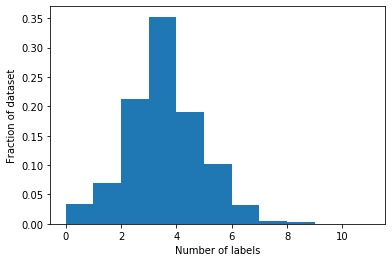

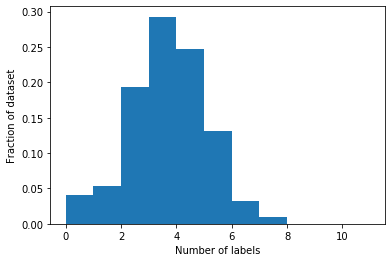

In [75]:
%matplotlib inline

from matplotlib import pyplot as plt


def plot_label_frequency(L):
    plt.hist(
        (L != ABSTAIN).sum(axis=1),
        density=True,
        bins=range(L.shape[1])
    )
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)
plot_label_frequency(L_dev)

### Interpretation

The overall label coverage looks good. Now we need to look at each label's coverage.

## Analyze the Labeling Functions' Performance

Overall label coverage is good but we need to make sure the distribution of our LF output is approximately even otherwise the label model won't have enough data with which to make good inferences about how LFs relate.

To help with this, we first prepare a `DataFrame` of label function names and their corresponding text labels to add to the `LFAnalysis.lf_summary` output to make it clearer what the coverage is for each label. 

In [76]:
# Prepare a name/label DataFrame to join to the LF Summary DataFrame below
lf_names = [lf.name for lf in lfs]
lf_labels = [lf._resources['label'] for lf in lfs]
lf_label_names = [{'Labels': number_to_name_dict[l]} for l in lf_labels]
label_name_df = pd.DataFrame(lf_label_names, index=lf_names)

label_name_df

,Labels
keyword_sdk_field_full_name,API
keyword_api_field_full_name,API
keyword_walkthrough_walk through_field_full_name_description_readme,API
keyword_skill_skills_field_full_name_description_readme,API
keyword_kit_kits_field_description_readme,API
keyword_extension_field_description_readme,API
keyword_amazon_field_description_readme,API
keyword_aws_field_full_name_description,API
keyword_integrate_integration_field_full_name_description_readme,API
keyword_/ion_field_full_name,GENERAL


### Run our `LFAnalysis` with Labels

Now we can run the LFAnalysis, get the summary and join our label names to see a clear indication of how well we're covering each label.

In [77]:
from snorkel.labeling import LFAnalysis

# Run the LF analysis on the gold labeled data
dev_lfa = LFAnalysis(L=L_dev, lfs=lfs)
dev_lfa_df = dev_lfa.lf_summary(Y=dev_labels.values)
dev_lfa_df['name'] = dev_lfa_df.index

# Join the label names in because the 'Polarity' field is confusing
lfa_label_df = dev_lfa_df.join(label_name_df)
lfa_label_df

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.,name,Labels
keyword_sdk_field_full_name,0,[1],0.045045,0.045045,0.000000,10,0,1.000000,keyword_sdk_field_full_name,API
keyword_api_field_full_name,1,[1],0.018018,0.018018,0.000000,4,0,1.000000,keyword_api_field_full_name,API
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.054054,0.054054,0.000000,11,1,0.916667,keyword_walkthrough_walk through_field_full_name_description_readme,API
keyword_skill_skills_field_full_name_description_readme,3,[1],0.076577,0.076577,0.000000,16,1,0.941176,keyword_skill_skills_field_full_name_description_readme,API
keyword_kit_kits_field_description_readme,4,[1],0.162162,0.157658,0.004505,31,5,0.861111,keyword_kit_kits_field_description_readme,API
keyword_extension_field_description_readme,5,[1],0.072072,0.072072,0.000000,15,1,0.937500,keyword_extension_field_description_readme,API
keyword_amazon_field_description_readme,6,[1],0.752252,0.738739,0.013514,150,17,0.898204,keyword_amazon_field_description_readme,API
keyword_aws_field_full_name_description,7,[1],0.833333,0.797297,0.000000,180,5,0.972973,keyword_aws_field_full_name_description,API
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.193694,0.193694,0.000000,41,2,0.953488,keyword_integrate_integration_field_full_name_description_readme,API
keyword_/ion_field_full_name,9,[0],0.013514,0.013514,0.013514,3,0,1.000000,keyword_/ion_field_full_name,GENERAL


## Determine Coverage by Label

Now we can group by the label and determine the raw count correct, incorrect and total. This will give us an idea of coverage per label.

In [78]:
g_lf_df = lfa_label_df.groupby('Labels').agg({'Correct': 'sum', 'Incorrect': 'sum'})
g_lf_df['Total LFs'] = g_lf_df['Correct'] + g_lf_df['Incorrect']
sum_total_lf = g_lf_df['Total LFs'].sum()
g_lf_df['Total LF Ratio'] = g_lf_df['Total LFs'] / sum_total_lf
g_lf_df['Total Correct Ratio'] = g_lf_df['Correct'] / sum_total_lf

g_lf_df

,Correct,Incorrect,Total LFs,Total LF Ratio,Total Correct Ratio
Labels,,,,,
API,667,44,711,0.995798,0.934174
GENERAL,3,0,3,0.004202,0.004202


## Compare to Gold Label Coverage

We need to compare this LF coverage to the raw gold label coverage, which will give us an idea of the disparity between the two.

In [79]:
dev_g_df = dev_df.groupby('label').agg({'full_name': 'count'})
dev_g_df

sum_total_labels = dev_g_df['full_name'].sum()
dev_g_df['Total Hand Label Ratio'] = dev_g_df['full_name'] / sum_total_labels
dev_g_df.columns = ['Total Labels', 'Total Hand Label Ratio']

dev_g_df

,Total Labels,Total Hand Label Ratio
label,,
API,195,0.878378
GENERAL,27,0.121622


In [80]:
combined_df = dev_g_df.join(g_lf_df)
combined_df

combined_df['LF / Label Ratio'] = combined_df['Total LF Ratio'] / combined_df['Total Hand Label Ratio']
combined_df['Correct LF / Label Ratio'] = combined_df['Total Correct Ratio'] / combined_df['Total Hand Label Ratio']

combined_df

,Total Labels,Total Hand Label Ratio,Correct,Incorrect,Total LFs,Total LF Ratio,Total Correct Ratio,LF / Label Ratio,Correct LF / Label Ratio
label,,,,,,,,,
API,195,0.878378,667,44,711,0.995798,0.934174,1.133678,1.063521
GENERAL,27,0.121622,3,0,3,0.004202,0.004202,0.034547,0.034547


### Interpretation

It looks like we are way over-covering `API` and way under covering `GENERAL`. Let's fix that!

## Determine Standout Tokens Per Class

Inspect the top 5 tokens in terms of TF-IDF per record then look for standouts per class.

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer


v = TfidfVectorizer()
m = v.fit_transform(dev_df['readme'])
index_to_word = dict([(value, key) for key, value in v.vocabulary_.items()])

term_rows = []
for row in m.toarray():
    words = []
    for i, val in enumerate(row):
        if val > 0:
            words.append((
                val,
                index_to_word[i]
            ))
    term_rows.append(
        [y[1] for y in sorted(words, key=lambda x: x[0], reverse=True)[0:5]]
    )

dev_df['top_terms'] = term_rows
df_short = dev_df[['full_name', 'description', 'label', 'top_terms', 'readme']]
api_df = df_short[df_short['label'] == 'GENERAL']

# See the READMEs
pd.set_option('display.max_colwidth', 300)
api_df = api_df[['full_name', 'description', 'label', 'top_terms', 'readme']]

api_df

,full_name,description,label,top_terms,readme
id,,,,,
21922630,twitchscience/gologging,A reliable s3 back logger,GENERAL,"[alexa, skill, calendar, skills, ask]","# Build An Alexa Calendar Reader Skill\n<img src=""https://m.media-amazon.com/images/G/01/mobile-apps/dex/alexa/alexa-skills-kit/tutorials/quiz-game/header._TTH_.png"" />\n\n[![Voice User Interface](https://m.media-amazon.com/images/G/01/mobile-apps/dex/alexa/alexa-skills-kit/tutorials/navigation/..."
107505869,firecracker-microvm/firecracker,Secure and fast microVMs for serverless computing.,GENERAL,"[ros2, ros, utils, workspace, the]",# AWS Utils Library for ROS2\n\n## Overview\nThis is the common library for all of AWS RoboMaker ROS2 packages.\nIt builds on top of the generic interfaces defined by [utils-common](https://github.com/aws-robotics/utils-common) to provide ROS2-specific helper functions and classes implementation...
30425273,c9/c9.ide.ace.gotoline,"The repository for c9.ide.ace.gotoline, a Cloud9 core plugin",GENERAL,"[lex, lex_node, ros, charset, plain]","# lex_node\n\n\n## Overview\nThe ROS `lex_node` node enables a robot to comprehend natural language commands by voice or textual input and respond through a set of actions, which an AWS Lex Bot maps to ROS messages. Out of the box this node provides a ROS interface to communicate with a specifie..."
4225718,c9/node-netutil,"utils to find free ports in a range, checking if a port is open, etc",GENERAL,[],
101670463,amzn/oss-contribution-tracker,Track contributions made to external projects and manage CLAs,GENERAL,"[spree, spree_amazon_payments, spree_pay_with_amazon, spree_social, bundle]","spree_pay_with_amazon\n===================\n\nAdd Pay with Amazon to your Spree Commerce solution.\n\nInstallation\n------------\n\nAdd spree_amazon_payments to your Gemfile:\n\n```\ngem 'spree_social', github: 'spree-contrib/spree_social', branch: '3-0-stable'\ngem 'spree_amazon_payments', gith..."
121417140,amzn/ion-test-driver,A cross-implementation test driver for Amazon Ion readers and writers.,GENERAL,[],
30425387,c9/c9.ide.language.javascript.immediate,"The repository for c9.ide.language.javascript.immediate, a Cloud9 core plugin",GENERAL,"[gotoline, ace, c9, ide]",# c9.ide.ace.gotoline\n
30425340,c9/c9.ide.remote,"The repository for c9.ide.remote, a Cloud9 core plugin",GENERAL,"[stripws, ace, c9, ide]",# c9.ide.ace.stripws\n
178966086,amzn/ion-kotlin-builder,This library provides Kotlin style type-safe builders for ion-java.,GENERAL,"[gameon, player, game, unity, tournament]","# GameOn Unity Starter Kit\n\nWith the GameOn Unity Starter Kit, Unity game developers can easily test all the basic endpoints that [GameOn Game API](https://developer.amazon.com/docs/gameon/game-api-ref.html) provides before even integrating them in their game client.\n\n## Getting Started\n\nT..."


## New LFs for API

We need some new LFs for API, so lets look at common n-grams of consequence for that class.

In [82]:
# Cloud9 is a GENERAL purpose project
cloud9_lf = make_keyword_lf(
    keywords=['cloud9', 'c9'],
    field=['full_name', 'description'],
    label=GENERAL,
)

# Open Distro is GENERAL
open_distro_lf = make_keyword_lf(
    keywords=['opendistro','open distro'],
    field=['full_name', 'description', 'readme'],
    label=GENERAL,
)

library_lf = make_keyword_lf(
    keywords=['library for'],
    field=['description'],
    label=GENERAL,
)

git_lf = make_keyword_lf(
    keywords=['protocol'],
    field=['full_name', 'description'],
    label=GENERAL,
)

# Add the LFs to one large list
lfs = [
    sdk_lf,
    api_lf,
    walkthrough_lf,
    skill_lf,
    kit_lf,
    extension_lf,
    amazon_lf,
    aws_lf,
    integration_lf,
    ion_lf,
    sample_lf,
    demo_lf,
    cloud9_lf,
    open_distro_lf,
    library_lf,
    git_lf,
]
lfs

# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 414/414 [00:00<00:00, 976.08it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_sdk_field_full_name,0,[1],0.045045,0.045045,0.000000,10,0,1.000000
keyword_api_field_full_name,1,[1],0.018018,0.018018,0.000000,4,0,1.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.054054,0.054054,0.000000,11,1,0.916667
keyword_skill_skills_field_full_name_description_readme,3,[1],0.076577,0.076577,0.000000,16,1,0.941176
keyword_kit_kits_field_description_readme,4,[1],0.162162,0.157658,0.013514,31,5,0.861111
keyword_extension_field_description_readme,5,[1],0.072072,0.072072,0.000000,15,1,0.937500
keyword_amazon_field_description_readme,6,[1],0.752252,0.743243,0.045045,150,17,0.898204
keyword_aws_field_full_name_description,7,[1],0.833333,0.797297,0.009009,180,5,0.972973
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.193694,0.193694,0.009009,41,2,0.953488
keyword_/ion_field_full_name,9,[0],0.013514,0.013514,0.013514,3,0,1.000000


In [115]:
train_lf_summary = LFAnalysis(L=L_train, lfs=lfs).lf_summary()
train_lf_summary

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_sdk_field_full_name,0,[1],0.077295,0.077295,0.000000
keyword_api_field_full_name,1,[1],0.019324,0.019324,0.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.041063,0.041063,0.002415
keyword_skill_skills_field_full_name_description_readme,3,[1],0.067633,0.065217,0.000000
keyword_kit_kits_field_description_readme,4,[1],0.144928,0.142512,0.004831
keyword_extension_field_description_readme,5,[1],0.072464,0.072464,0.004831
keyword_amazon_field_description_readme,6,[1],0.775362,0.763285,0.036232
keyword_aws_field_full_name_description,7,[1],0.840580,0.801932,0.026570
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.178744,0.178744,0.009662
keyword_/ion_field_full_name,9,[0],0.009662,0.009662,0.009662


In [116]:
train_lf_summary['Polarity'] = train_lf_summary['Polarity'].apply(lambda x: x[0])

gen_lf_summary = train_lf_summary[train_lf_summary['Polarity'] == 0]
api_lf_summary = train_lf_summary[train_lf_summary['Polarity'] == 1]

gen_lf_summary

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_/ion_field_full_name,9,0,0.009662,0.009662,0.009662
keyword_cloud9_c9_field_full_name_description,12,0,0.048309,0.026570,0.026570
keyword_opendistro_open distro_field_full_name_description_readme,13,0,0.009662,0.007246,0.007246
keyword_library for_field_description,14,0,0.012077,0.012077,0.012077
keyword_protocol_field_full_name_description,15,0,0.004831,0.002415,0.002415


In [114]:
gen_lf_summary.agg('Coverage').sum(), gen_lf_summary.agg('Overlaps').sum(), gen_lf_summary.agg('Conflicts').sum()

(0.08454106280193235, 0.05797101449275362, 0.05797101449275362)

In [117]:
api_lf_summary

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_sdk_field_full_name,0,1,0.077295,0.077295,0.000000
keyword_api_field_full_name,1,1,0.019324,0.019324,0.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,1,0.041063,0.041063,0.002415
keyword_skill_skills_field_full_name_description_readme,3,1,0.067633,0.065217,0.000000
keyword_kit_kits_field_description_readme,4,1,0.144928,0.142512,0.004831
keyword_extension_field_description_readme,5,1,0.072464,0.072464,0.004831
keyword_amazon_field_description_readme,6,1,0.775362,0.763285,0.036232
keyword_aws_field_full_name_description,7,1,0.840580,0.801932,0.026570
keyword_integrate_integration_field_full_name_description_readme,8,1,0.178744,0.178744,0.009662
keyword_sample_field_full_name_description_readme,10,1,0.618357,0.618357,0.031401


In [118]:
api_lf_summary.agg('Coverage').sum(), api_lf_summary.agg('Overlaps').sum(), api_lf_summary.agg('Conflicts').sum()

(3.055555555555556, 3.0, 0.13285024154589373)